## 1. libraries import and setup

In [1]:
import geopandas as gpd
import rioxarray as rxr
from rioxarray.merge import merge_datasets
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject
import numpy as np
import xarray as xr
from scipy.ndimage import generic_filter
from scipy.interpolate import griddata
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\nDSMs
created directory data\raw_data\DOPs
created directory data\raw_data\orga
created directory data\processed_data\nDSMs
created directory data\processed_data\DOPs
created directory data\processed_data\datasets
created directory data\processed_data\gap_polygons_ALS
created directory data\processed_data\models
created directory data\processed_data\test_areas
created directory data\metadata
created directory output


## 2. data reading and preprocessing

### 2.1 nDSMs/CHMs
For testing, image-based (stereoscopic) normalized digital surface models (nDSM) (also referred to as canopy height model (CHM)) are used. They were calculated with a spatial resolution of 0.5 m. Here, they are clipped to the respective digital orthophoto (DOP). For this reason, the single DOPs are already read in here. Missing values (NaN) in the clipped nDSMs are interpolated using nearest neighbor method. After clipping and interpolation of NaN values, the nDSMs are smoothed using a moving window of 3x3 cells to calculate focal mean.

In [3]:
# define path to raw DOPs
dop_solling_path = raw_data_dir / 'DOPs'

# read raw DOP
dop_test = rxr.open_rasterio(dop_solling_path / 'dop_test.tif',
                             band_as_variable = True)

# assign CRS
dop_test.rio.write_crs('epsg:25832', inplace=True)

print(dop_test)

<xarray.Dataset>
Dimensions:      (x: 25000, y: 25000)
Coordinates:
  * x            (x) float64 5.428e+05 5.428e+05 ... 5.445e+05 5.445e+05
  * y            (y) float64 5.738e+06 5.738e+06 ... 5.737e+06 5.737e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint16 ...
    band_2       (y, x) uint16 ...
    band_3       (y, x) uint16 ...
    band_4       (y, x) uint16 ...
Attributes:
    AREA_OR_POINT:  Area


In [5]:
# define path to raw nDSM files
ndsm_solling_path = raw_data_dir / 'nDSMs'

# define path to the clipped nDSMs files
ndsm_test_clipped_file  = processed_data_dir / 'nDSMs' / 'ndsm_test_lev2.tif'

# function to interpolate NaN values
def interpolate_nan(array):

    x, y = np.indices(array.shape)
    non_nan_elements = ~np.isnan(array)
    
    # coordinates and values of non-NaN elements
    known_x = x[non_nan_elements]
    known_y = y[non_nan_elements]
    known_values = array[non_nan_elements]
    
    # coordinates of NaN elements
    missing_x = x[np.isnan(array)]
    missing_y = y[np.isnan(array)]
    
    # interpolate and fill NaNs
    array[np.isnan(array)] = griddata(
        (known_x, known_y), known_values, (missing_x, missing_y), method='nearest'
    )
    
    return array

# check if clipped nDSM files already exists
if not ndsm_test_clipped_file.exists():
    
    # read raw nDSM    
    ndsm_solling_test  = rxr.open_rasterio(ndsm_solling_path / 'ndsm_solling_test_area_lev2.tif',
                                           band_as_variable=True)
    
    ndsm_solling_test.rio.write_crs('epsg:25832', inplace=True)

    # get the bounding box of dop_test
    bounds_dop_test  = dop_test.rio.bounds()

    # clip CHMs to the extent of the DOPs
    print('clipping...')
    ndsm_test_clipped  = ndsm_solling_test.rio.clip_box(*bounds_dop_test)
    
    # interpolate NaN values
    print('interpolation...')
    ndsm_test_clipped['band_1'].values  = interpolate_nan(ndsm_test_clipped['band_1'].values)
    
    # smooth the clipped nDSMs
    print('smoothing...')
    ndsm_test_clipped['band_1'].values = generic_filter(
        ndsm_test_clipped['band_1'].values,
        function=np.nanmean,
        size=3,
        mode='reflect'
    )

    # save clipped and smoothed nDSM
    ndsm_test_clipped.rio.to_raster(ndsm_test_clipped_file)
    print('nDSMs successfully clipped, smoothed, and saved.')

else:

    # load existing clipped and smoothed nDSMs
    ndsm_test  = rxr.open_rasterio(ndsm_test_clipped_file, band_as_variable=True)
    print('Existing clipped and smoothed nDSMs loaded.')

Existing clipped and smoothed nDSMs loaded.


### 2.2 DOPs
The DOPs come in a spatial resolution of 0.07 m. Therefore, they must be resampled to the resolution of the nDSMs (0.5 m).

In [6]:
# define path to raw DOPs
dop_solling_path = raw_data_dir / 'DOPs'

# define path to the downsampled DOP files
dop_test_downsampled_file = processed_data_dir / 'DOPs' / 'dop_test.tif'

# check if downsampled DOP files already exists
if not dop_test_downsampled_file.exists():
    
    # read DOPs
    dop_test = rxr.open_rasterio(dop_solling_path / 'dop_test.tif',
                                 band_as_variable=True)

    # assign CRS
    dop_test.rio.write_crs('epsg:25832', inplace=True)
    
    # normalization and conversion to uint8
    #---------------------------------------
    def normalize_and_convert_to_uint8(dataset):

        for band in dataset:
            
            # get maximum value of each band
            max_value     = dataset[band].max()
        
            # normalize the band to the range 0-255
            dataset[band] = (dataset[band] / max_value) * 255
        
            # convert to uint8
            dataset[band] = dataset[band].astype('uint8')
        
        return dataset

    # normalize and convert DOPs to uint8
    dop_test = normalize_and_convert_to_uint8(dop_test)
    
    # downsampling process
    #----------------------
    
    # calculate downscale factors
    downscale_factor_x = ndsm_test.rio.width / dop_test.rio.width
    downscale_factor_y = ndsm_test.rio.height / dop_test.rio.height
    
    # calculate new heights and widths
    x_downscaled = dop_test.rio.width * downscale_factor_x_train
    y_downscaled = dop_test.rio.height * downscale_factor_y_train
    
    # downsample the DOP
    dop_test_downsampled = dop_test.rio.reproject(
        dop_test.rio.crs,
        shape=(int(y_downscaled), int(x_downscaled)),
        resampling=Resampling.bilinear,
        nodata=None
        )
    
    # save downsampled DOP
    dop_test_downsampled.rio.to_raster(dop_test_downsampled_file)
    print('DOP successfully downsampled and saved.')

else:

    # load existing downsampled DOPs
    dop_test = rxr.open_rasterio(dop_test_downsampled_file, band_as_variable=True)
    print('Existing downsampled DOPs loaded.')

Existing downsampled DOPs loaded.


### 2.3 gap polygons
Gap polygons were previously generated automatically from the ALS-based CHM. See script "gap_generation.R".

       FID                                           geometry
0        0  POLYGON ((542805.500 5738250.000, 542808.500 5...
1        1  POLYGON ((542838.500 5738250.000, 542842.500 5...
2        2  POLYGON ((542852.000 5738250.000, 542856.500 5...
3        3  POLYGON ((543019.000 5738250.000, 543024.500 5...
4        4  MULTIPOLYGON (((543100.500 5738250.000, 543107...
...    ...                                                ...
1786  1786  POLYGON ((544096.000 5736508.000, 544097.500 5...
1787  1787  POLYGON ((543056.000 5736506.000, 543056.500 5...
1788  1788  POLYGON ((543399.000 5736505.500, 543401.000 5...
1789  1789  POLYGON ((543303.500 5736505.000, 543304.500 5...
1790  1790  POLYGON ((544499.500 5736505.000, 544500.000 5...

[1791 rows x 2 columns]


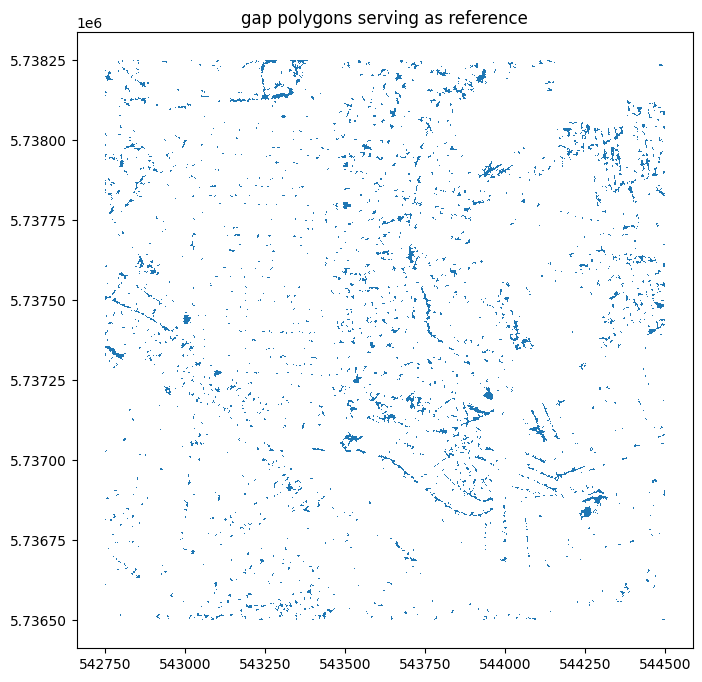

In [7]:
# read gap polygons
gap_polys_path = processed_data_dir / 'gap_polygons_ALS'

gap_polys_test = gpd.read_file(gap_polys_path / 'gap_polys_test_new_approach_5m_10sqm.shp')

print(gap_polys_test)

# quick overview of the gap polygons
fig, ax = plt.subplots(figsize=(14,8))
gap_polys_test.plot(ax=ax)
ax.set_title('gap polygons serving as reference')
plt.show()

## 3. creation of one dataset
### 3.1 merge nDSM and DOP into one dataset

In [8]:
# make copies of DOP dataset
dop_test_copy = dop_test.copy()

# add nDSM as variable to DOP (copy) dataset
dop_test_copy['ndsm'] = (['y','x'], ndsm_test['band_1'].values)

# copy the attributes
dop_test_copy['ndsm'].attrs = ndsm_test['band_1'].attrs

# convert spectral bands to float32 and 
# ensure equal NoData values
for band in dop_test_copy.data_vars:
    dop_test_copy[band] = dop_test_copy[band].astype('float32')
    dop_test_copy[band].rio.write_nodata(np.nan, inplace=True)
    
# rename the dataset
test_ds = dop_test_copy

print(test_ds)

<xarray.Dataset>
Dimensions:      (x: 3501, y: 3500)
Coordinates:
  * x            (x) float64 5.428e+05 5.428e+05 ... 5.445e+05 5.445e+05
  * y            (y) float64 5.738e+06 5.738e+06 ... 5.737e+06 5.737e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 148.0 151.0 144.0 146.0 ... 153.0 154.0 167.0
    band_2       (y, x) float32 154.0 158.0 154.0 157.0 ... 169.0 169.0 173.0
    band_3       (y, x) float32 119.0 122.0 114.0 114.0 ... 132.0 133.0 144.0
    band_4       (y, x) float32 179.0 186.0 188.0 192.0 ... 198.0 197.0 194.0
    ndsm         (y, x) float32 25.65 24.29 22.66 ... 0.061 0.06733 0.07367
Attributes:
    AREA_OR_POINT:  Area


### 3.2 add canopy gaps as raster mask to the dataset

In [9]:
# get geometries of the gap polygons
geom_test = [shapes for shapes in gap_polys_test.geometry]

# get parameters of the nDSM needed for the mask
with rasterio.open(processed_data_dir / 'nDSMs' / 'ndsm_test.tif') as src:
    profile_test = src.profile

# rasterize the polygons
# --> values 0 (non-gap) and 1 (gap)
test_mask = rasterize(
    geom_test,
    out_shape = (profile_test['height'], profile_test['width']),
    fill=0,
    transform=profile_test['transform'],
    all_touched=True,
    default_value=1
)

# add the mask to the dataset
test_ds['gap_mask'] = (['y','x'], test_mask)

# set attributes for gap_mask
fill_value_attrs = {
    '_FillValue': np.nan,
    'long_name': 'gap_mask',
}

# apply these attributes to gap_mask in the dataset
test_ds['gap_mask'].attrs.update(fill_value_attrs)

# convert to float32
test_ds['gap_mask'] = test_ds['gap_mask'].astype('float32')

print(test_ds)

<xarray.Dataset>
Dimensions:      (x: 3501, y: 3500)
Coordinates:
  * x            (x) float64 5.428e+05 5.428e+05 ... 5.445e+05 5.445e+05
  * y            (y) float64 5.738e+06 5.738e+06 ... 5.737e+06 5.737e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 148.0 151.0 144.0 146.0 ... 153.0 154.0 167.0
    band_2       (y, x) float32 154.0 158.0 154.0 157.0 ... 169.0 169.0 173.0
    band_3       (y, x) float32 119.0 122.0 114.0 114.0 ... 132.0 133.0 144.0
    band_4       (y, x) float32 179.0 186.0 188.0 192.0 ... 198.0 197.0 194.0
    ndsm         (y, x) float32 25.65 24.29 22.66 ... 0.061 0.06733 0.07367
    gap_mask     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 0.0
Attributes:
    AREA_OR_POINT:  Area


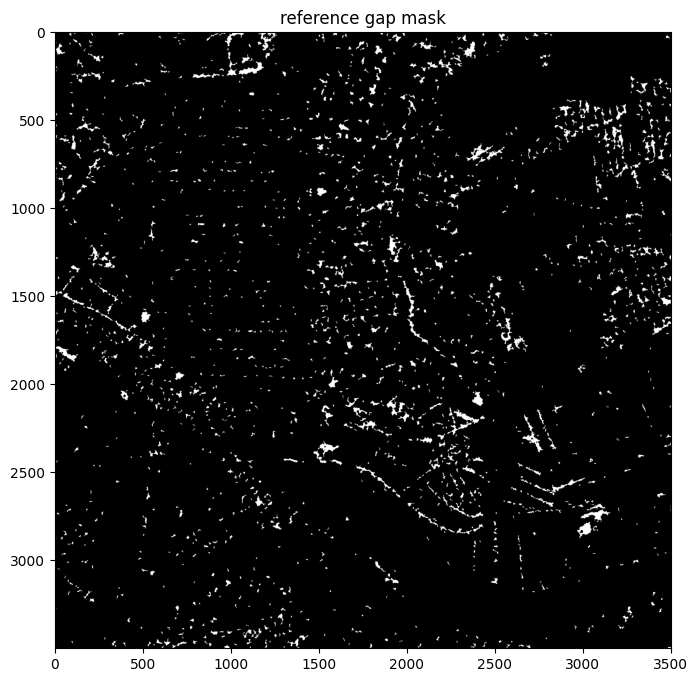

In [12]:
# plot the reference gap mask
fig, ax = plt.subplots(figsize=(14,8))
ax.imshow(test_ds.gap_mask, cmap='gray')
ax.set_title('reference gap mask')
plt.show()

### 3.3 rename spectral bands in the dataset and save it to disk

In [10]:
# rename spectral bands
new_variable_names = {'band_1': 'red', 'band_2': 'green', 'band_3': 'blue', 'band_4': 'nir'}
test_ds = test_ds.rename(new_variable_names)

# dictionary mapping new variable names to their long names
long_names = {
    'red'  : 'red',
    'green': 'green',
    'blue' : 'blue',
    'nir'  : 'nir',
    'ndsm' : 'ndsm'
}

# function to update the long_name attribute
def update_long_names(dataset, long_name_mapping):
    for var_name, long_name in long_name_mapping.items():
        if var_name in dataset:
            dataset[var_name].attrs['long_name'] = long_name

# update long_name in the dataset
update_long_names(test_ds, long_names)

In [12]:
# save final dataset to disk
#-----------------------------
# define path to final dataset files
# (as tif and csv)
test_ds_tif_file = processed_data_dir / 'datasets' / 'test_ds_lev2.tif'
test_ds_csv_file = processed_data_dir / 'datasets' / 'test_ds_lev2.csv'

# check if final dataset already exists
if not test_ds_tif_file.exists() or not test_ds_csv_file.exists():
    
    # save dataset 
    # as tif
    test_ds.rio.to_raster(test_ds_tif_file)
    # as csv
    df_test = test_ds.to_dataframe()
    df_test.to_csv(test_ds_csv_file)
    
    print('Test dataset saved.')
    
else:
    
    # load existing dataset
    test_ds = rxr.open_rasterio(test_ds_tif_file, band_as_variable=True)

    # use the long_names as variable names 
    for var_name in test_ds.data_vars:
        long_name = test_ds[var_name].attrs['long_name']
        test_ds = test_ds.rename({var_name: long_name})
        
    print('Existing test dataset loaded.')

Existing test dataset loaded.


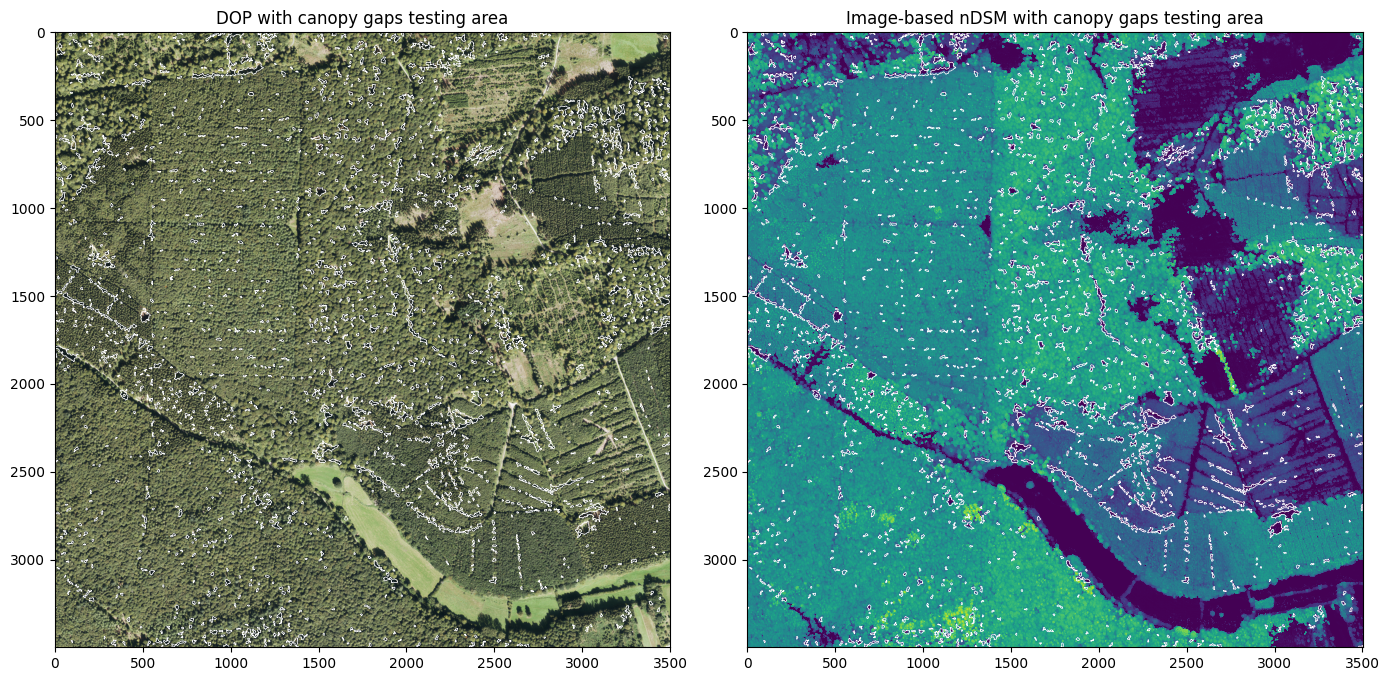

In [13]:
# final plot
#------------

# normalize RGB bands to [0, 1] range
test_rgb_norm = np.stack([test_ds.red, test_ds.green, test_ds.blue]).transpose(1,2,0)
test_rgb_norm = (test_rgb_norm - test_rgb_norm.min()) / (test_rgb_norm.max() - test_rgb_norm.min())

# plot RGB-DOP and nDSM with gap mask testing area
fig, ax = plt.subplots(1,2, figsize=(14,16))
ax[0].imshow(test_rgb_norm)
ax[0].contour(test_ds.gap_mask, levels=[0], colors='white', linewidths=0.5, linestyles='solid')
ax[0].set_title('DOP with canopy gaps testing area')
ax[1].imshow(test_ds.ndsm, cmap='viridis', interpolation='none')
ax[1].contour(test_ds.gap_mask, levels=[0], colors='white', linewidths=0.5, linestyles='solid')
ax[1].set_title('Image-based nDSM with canopy gaps testing area')
plt.tight_layout()
plt.show()